
<p style="text-align:center;">SME0828 - Introdução à Ciência de Dados</p>

<p style="text-align:center;">Projeto Final</p>


<p style="text-align:center;">Hugo de Oliveira Borges nUSP: 11915202</p>

* Pergunta Principais
    * Existe sazonalidade?
    * Previsão da concentração de poluentes com relaçõa à temperatura.
    * Qual modelo se sai melhor, comparando RMSE, MAE e $R^2$?
    * Qual é a limitação dos dados?

* Perguntas de correlação
    * Quais poluentes estão mais correlacionados entre si?
    * Como variáveis meteorológicas (temperatura, umidade, pressão, velocidade do vento) influenciam as concentrações de poluentes?

* Qual modelo (linear, árvore) tem melhor desempenho para prever poluição?


### Introdução:

A base de dados apresentam respostas de dispositivos de gás implatados em uma cidade italiana. As médias das respostas horárias são registradas juntamente com as referências de concentração de gás de um analisador certificado.

### <p style="text-align:center;">Variáveis da base de dados suas descrições e unidades</p>


| Variável          | Descrição                                                           | Unidade     |
| ----------------- | ------------------------------------------------------------------- | ----------- |
| **Date**          | Data da medição                                                     | DD/MM/AAAA  |
| **Time**          | Hora da medição                                                     | HH.MM.SS    |
| **CO(GT)**        | Concentração verdadeira de monóxido de carbono (referência oficial) | mg/m³       |
| **PT08.S1(CO)**   | Sinal do sensor de CO (óxido de estanho, SnO₂)                      | ARB (adim.) |
| **NMHC(GT)**      | Concentração verdadeira de hidrocarbonetos não metânicos            | ppb         |
| **C6H6(GT)**      | Concentração verdadeira de benzeno                                  | µg/m³       |
| **PT08.S2(NMHC)** | Sinal do sensor de NMHC (titânia, TiO₂)                             | ARB (adim.) |
| **NOx(GT)**       | Concentração verdadeira de óxidos de nitrogênio                     | ppb         |
| **PT08.S3(NOx)**  | Sinal do sensor de NOx (óxido de tungstênio, W)                     | ARB (adim.) |
| **NO₂(GT)**       | Concentração verdadeira de dióxido de nitrogênio                    | µg/m³       |
| **PT08.S4(NO₂)**  | Sinal do sensor de NO₂ (óxido de tungstênio, W)                     | ARB (adim.) |
| **PT08.S5(O₃)**   | Sinal do sensor de ozônio (óxido de estanho, SnO₂)                  | ARB (adim.) |
| **T**             | Temperatura do ar                                                   | °C          |
| **RH**            | Umidade relativa                                                    | %           |
| **AH**            | Umidade absoluta                                                    | g/m³        |


* Onde **GT** $=$ Ground Truth, sendo uma medida oficial;
* **PT08.Sx** $ = $ São leituras de sensores químicos, em unidade ARB (Analog-to-Digital Converter Output).


In [31]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import matplotlib as plt
import plotly.express as px

# Modelos de Regressão
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
random.seed(96)

warnings.filterwarnings('ignore')

[Base de dados utilizada](https://archive.ics.uci.edu/dataset/360/air+quality)

In [32]:
# Obtendo dados do UCI Machine Learning Repository

#pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
air_quality = fetch_ucirepo(id=360) 

df = air_quality.data.features

### <p style="text-align:center;">Tratamento inicial dos dados</p>


### Criação da coluna Datetime 
*   Facilitar a vizualização;
*   Resample;
*   Extrair os dados componentes (hora do dia, dia da semana e mês) para a sazonalidade;

In [33]:
# Substituir Date e Time pela coluna datetime
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')

# Remover as colunas originais de data e hora
df = df.drop(columns=['Date', 'Time'])

# Reorganizar para deixar datetime no início
df = df[['datetime'] + [col for col in df.columns if col != 'datetime']]

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       9357 non-null   datetime64[ns]
 1   CO(GT)         9357 non-null   float64       
 2   PT08.S1(CO)    9357 non-null   int64         
 3   NMHC(GT)       9357 non-null   int64         
 4   C6H6(GT)       9357 non-null   float64       
 5   PT08.S2(NMHC)  9357 non-null   int64         
 6   NOx(GT)        9357 non-null   int64         
 7   PT08.S3(NOx)   9357 non-null   int64         
 8   NO2(GT)        9357 non-null   int64         
 9   PT08.S4(NO2)   9357 non-null   int64         
 10  PT08.S5(O3)    9357 non-null   int64         
 11  T              9357 non-null   float64       
 12  RH             9357 non-null   float64       
 13  AH             9357 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(8)
memory usage: 1023.6 KB
None


#### Análises iniciais
##### Limpeza e preparação dos dados

In [34]:
# Conferindo valores faltantes por sensor
missing_per_col = df.isna().mean().sort_values(ascending=False)
print("\nPercentual de missing por coluna:")
print(missing_per_col)



Percentual de missing por coluna:
datetime         0.0
CO(GT)           0.0
PT08.S1(CO)      0.0
NMHC(GT)         0.0
C6H6(GT)         0.0
PT08.S2(NMHC)    0.0
NOx(GT)          0.0
PT08.S3(NOx)     0.0
NO2(GT)          0.0
PT08.S4(NO2)     0.0
PT08.S5(O3)      0.0
T                0.0
RH               0.0
AH               0.0
dtype: float64


Observando os valores faltantes vemos que o composto $NMHC(GT)$ tem $90\%$ dos valores faltantes, portanto, vamos descartar a coluna

In [35]:
df.drop('NMHC(GT)', axis=1, inplace=True)

Na base de dados é dito que existem valores faltantes e são marcados com o valor $-200$

In [36]:

df_original = df.copy()
# Removendo valores faltantes
df.replace(-200, np.nan, inplace=True)

print(df.isnull())

# Remover linhas restantes com NaN
df = df.dropna()

      datetime  CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0        False   False        False     False          False    False   
1        False   False        False     False          False    False   
2        False   False        False     False          False    False   
3        False   False        False     False          False    False   
4        False   False        False     False          False    False   
...        ...     ...          ...       ...            ...      ...   
9352     False   False        False     False          False    False   
9353     False   False        False     False          False    False   
9354     False   False        False     False          False    False   
9355     False   False        False     False          False    False   
9356     False   False        False     False          False    False   

      PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)      T     RH     AH  
0            False    False         False    

In [37]:
# Estimativa Numérica
df.describe()

,datetime,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,6941,6941.000000,6941.000000,6941.000000,6941.000000,6941.000000,6941.000000,6941.000000,6941.000000,6941.000000,6941.000000,6941.000000,6941.000000
mean,2004-09-28 01:45:40.066272896,2.182467,1119.913269,10.554488,958.543005,250.671949,816.893387,113.874082,1452.648898,1057.756519,17.755323,48.881905,0.985573
min,2004-03-10 18:00:00,0.100000,647.000000,0.200000,390.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,2004-06-15 05:00:00,1.100000,956.000000,4.900000,760.000000,103.000000,642.000000,79.000000,1207.000000,760.000000,11.200000,35.300000,0.694100
50%,2004-10-08 05:00:00,1.900000,1085.000000,8.800000,931.000000,186.000000,786.000000,110.000000,1457.000000,1006.000000,16.800000,49.200000,0.953900
75%,2005-01-12 18:00:00,2.900000,1254.000000,14.600000,1135.000000,335.000000,947.000000,142.000000,1683.000000,1322.000000,23.700000,62.200000,1.251600
max,2005-04-04 14:00:00,11.900000,2040.000000,63.700000,2214.000000,1479.000000,2683.000000,333.000000,2775.000000,2523.000000,44.600000,88.700000,2.180600
std,NaN,1.441158,218.733754,7.465226,264.055002,208.611371,251.897200,47.475017,353.301576,406.509957,8.844909,17.433193,0.401097


### <p style="text-align:center;">Análise Exploratória dos Dados</p>


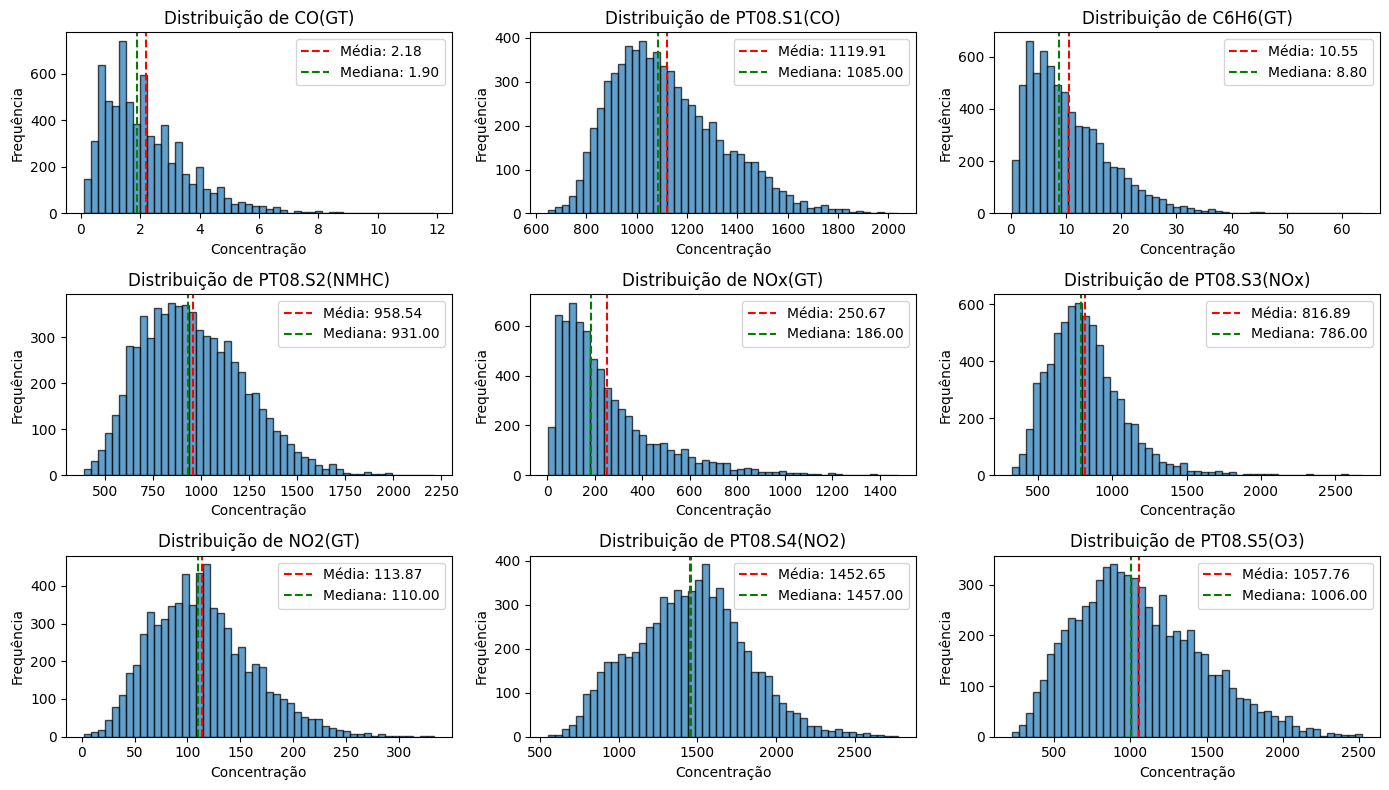

In [38]:
import matplotlib.pyplot as plt

# Identificar colunas de sensores e poluentes
sensor_columns = [col for col in df.columns if 'PT08' in col]
pollutant_columns = [
    'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)',
    'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)'
]

# Plot distribuições dos poluentes
fig, axes = plt.subplots(3, 3, figsize=(14, 8))
axes = axes.ravel()

for i, col in enumerate(pollutant_columns):
    if col in df.columns:
        axes[i].hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
        axes[i].set_title(f'Distribuição de {col}')
        axes[i].set_xlabel('Concentração')
        axes[i].set_ylabel('Frequência')

        # Adicionar estatísticas
        mean_val = df[col].mean()
        median_val = df[col].median()
        axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Média: {mean_val:.2f}')
        axes[i].axvline(median_val, color='green', linestyle='--', label=f'Mediana: {median_val:.2f}')
        axes[i].legend()
    else:
        axes[i].set_visible(False)

plt.tight_layout()
plt.show()


Os histogramas mostram que $CO$, $NO_x$, $NO_2$ e $C_6H_6$ não seguem distribuições normais. Em todos os casos, há assimetria à direita e presença de caudas longas, exceto quando se trata do $NO_2$ o que significa que a maior parte das medições se concentra em valores baixos, porém, existem episódios de concentração alta. Isso deve ocorrer em áreas urbanas, onde a poluição se mantém em níveis moderados.

Agora, será analisado a concentração dos gases com a variação da temperatura

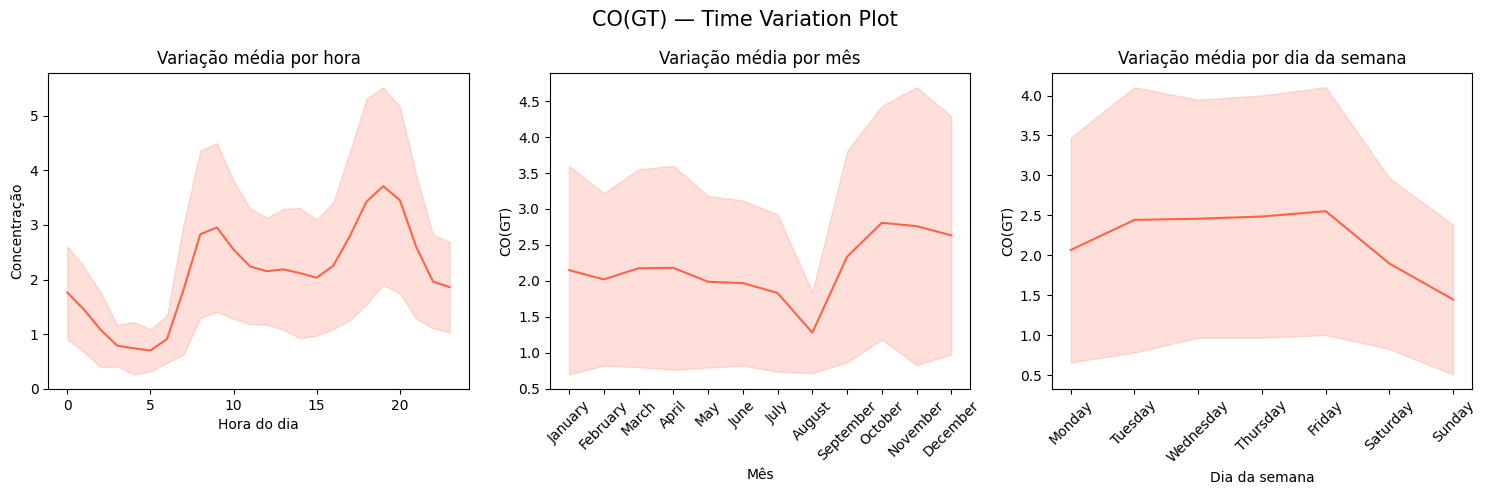

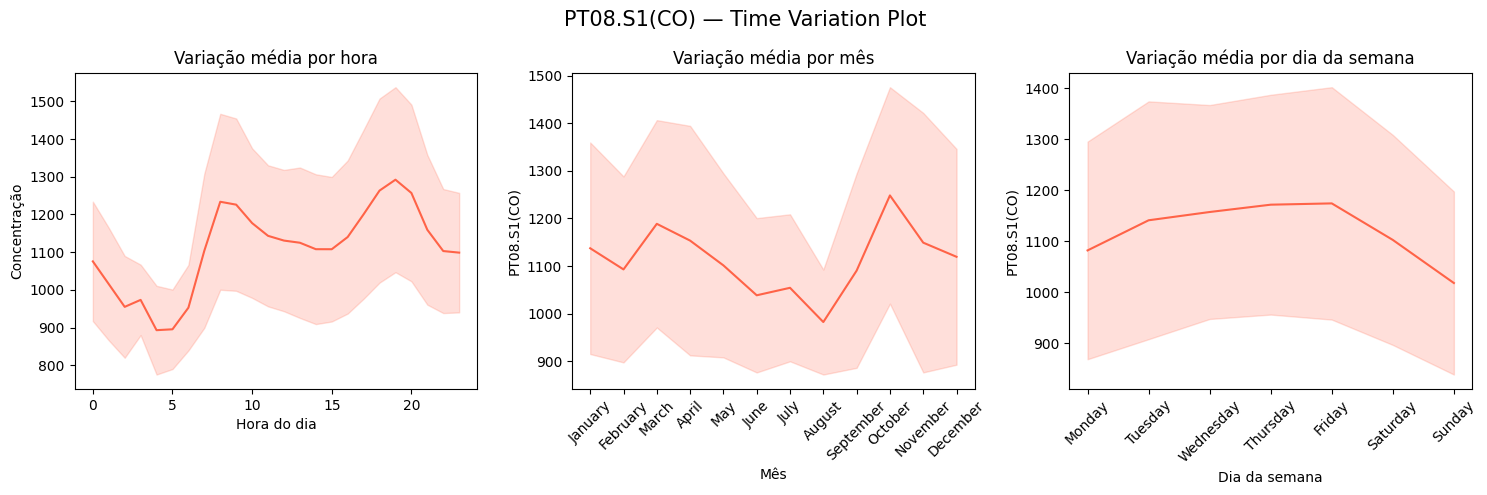

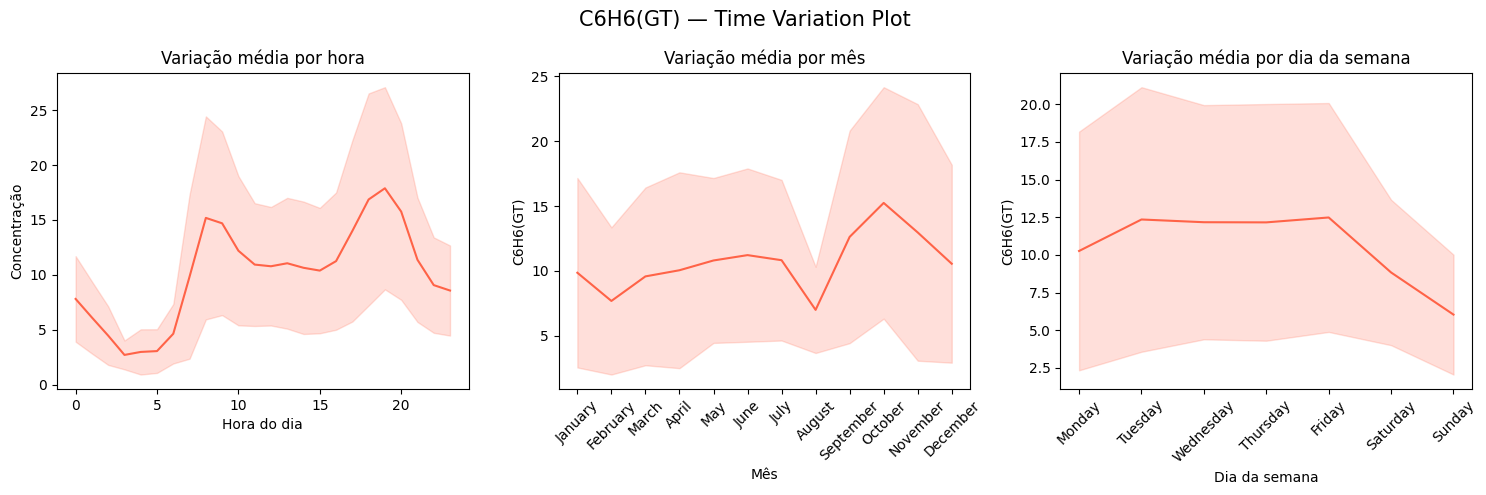

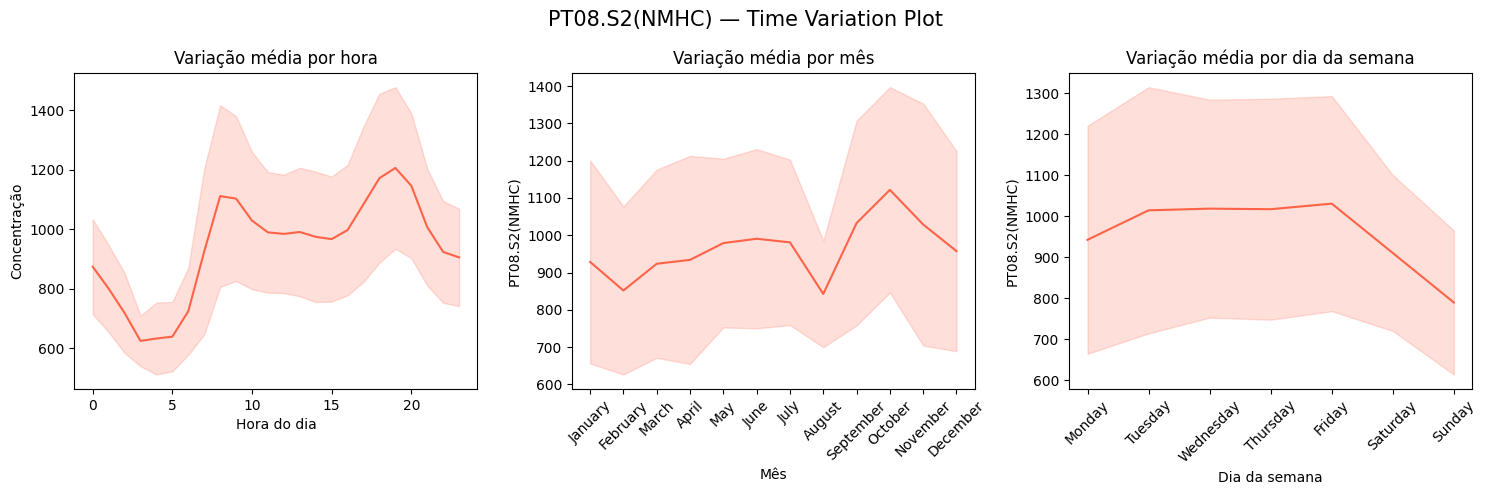

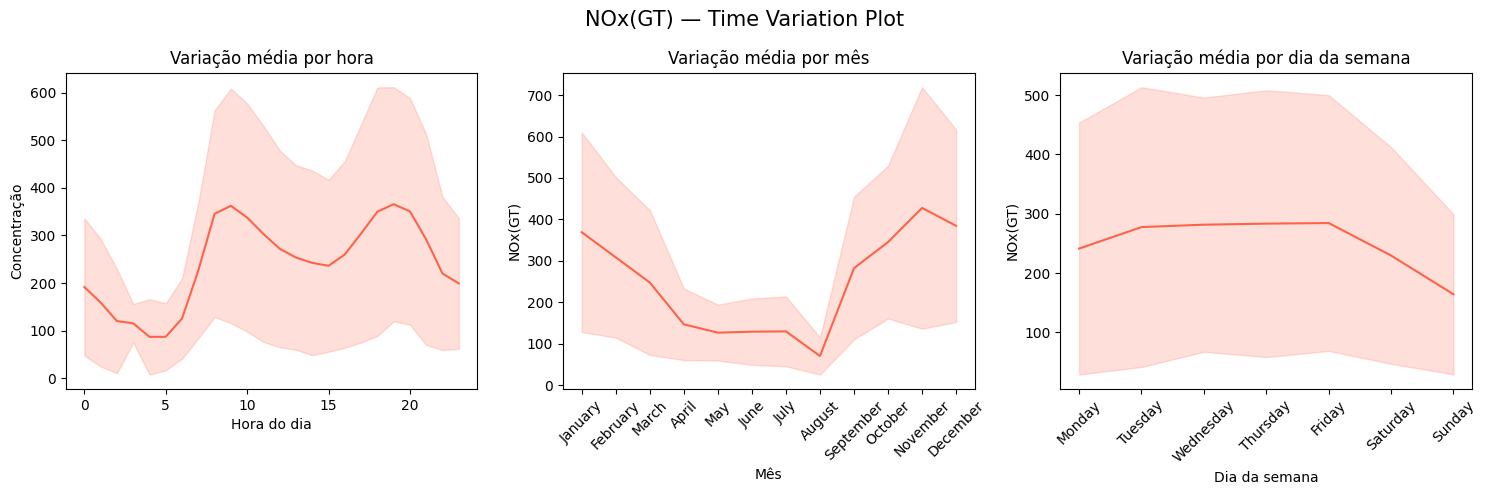

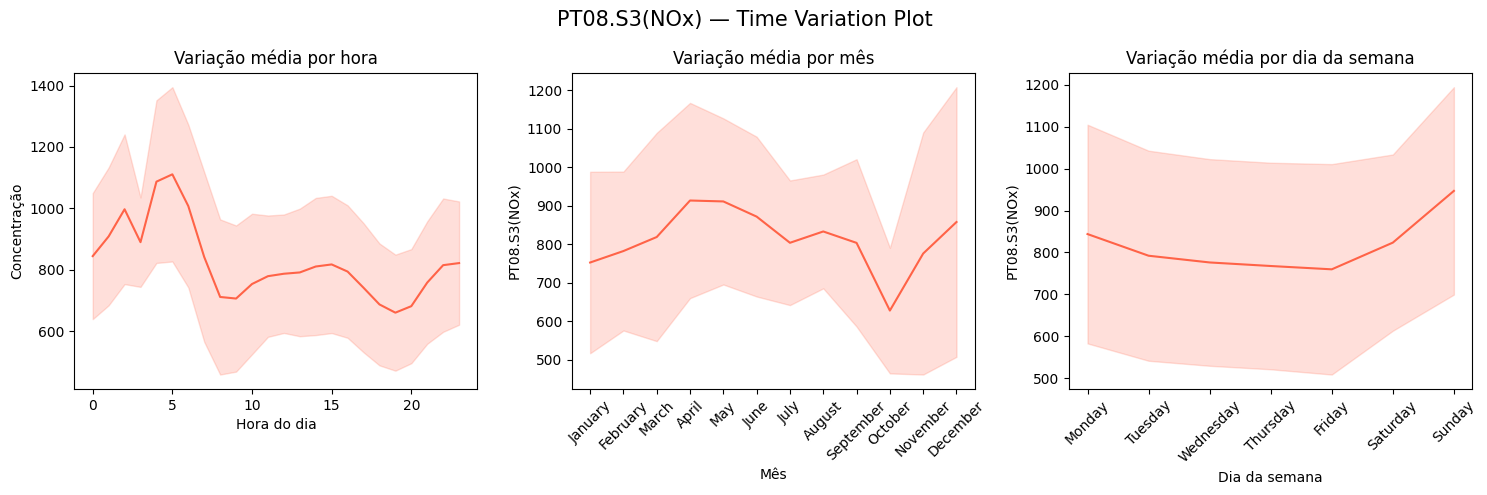

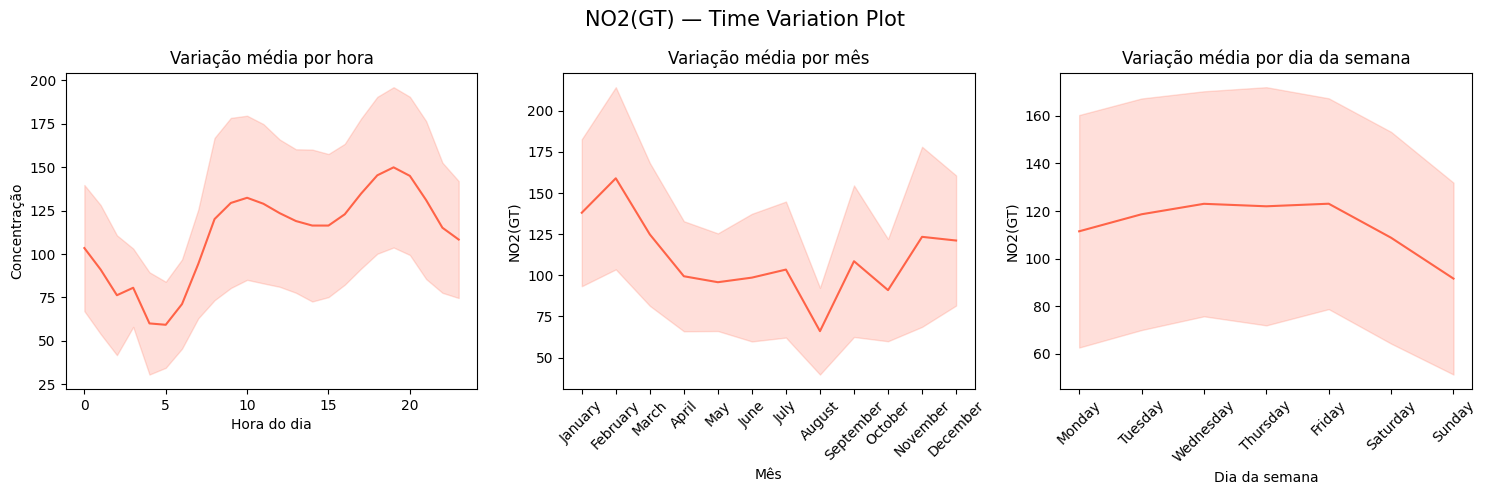

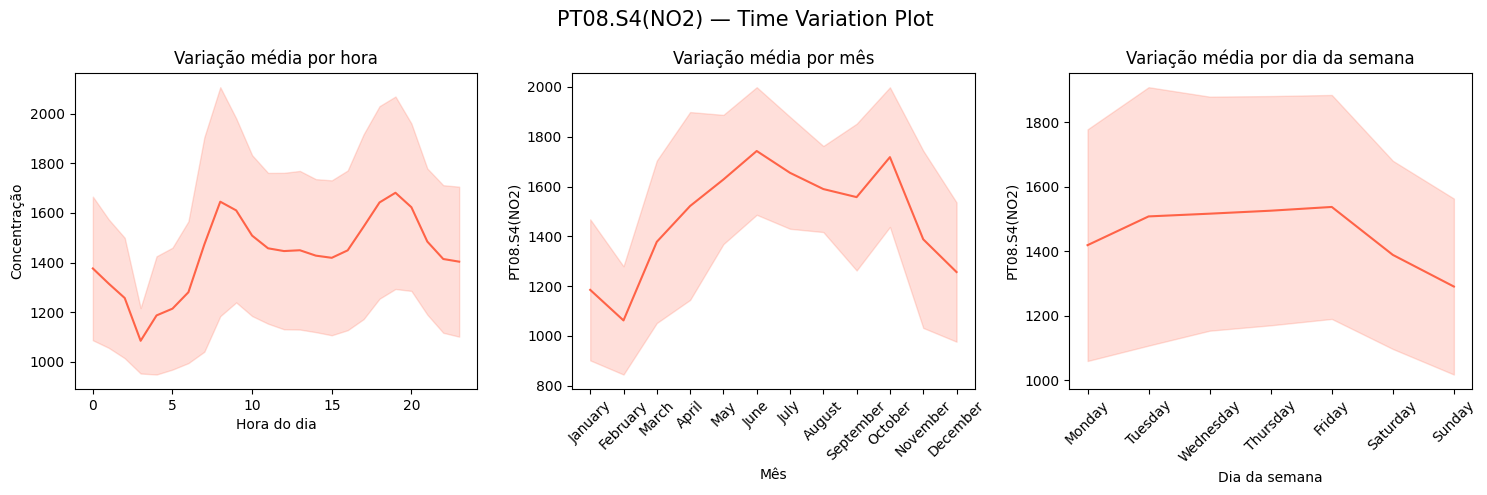

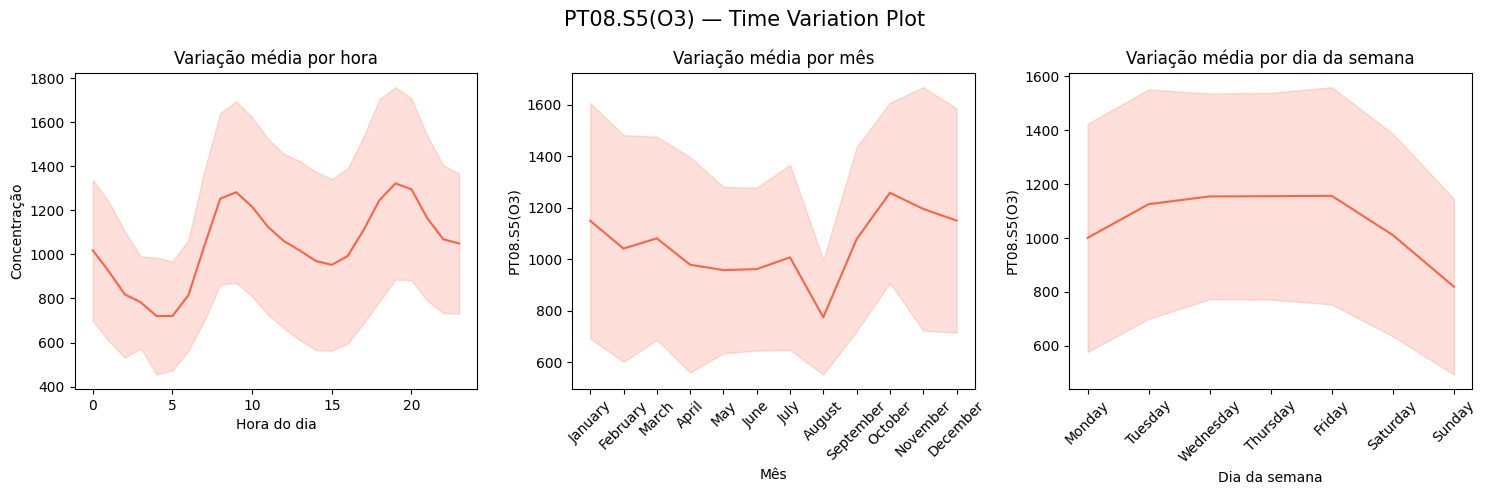

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# FUNÇÃO: Gráficos de variação temporal

def plot_time_variation(df, pollutant):
    """Gera gráficos de variação horária, mensal e semanal de um poluente."""

    df = df.set_index("datetime")

    # Extrair colunas temporais
    df["hour"] = df.index.hour
    df["weekday"] = df.index.day_name()
    df["month"] = df.index.month_name()

    # Definir ordem correta
    order_meses = ["January","February","March","April","May","June","July","August","September","October","November","December"]
    order_dias = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

    df["month"] = pd.Categorical(df["month"], categories=order_meses, ordered=True)
    df["weekday"] = pd.Categorical(df["weekday"], categories=order_dias, ordered=True)

    # Criar figura
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    fig.suptitle(f"{pollutant} — Time Variation Plot", fontsize=15)

    # Variação média por hora
    sns.lineplot(ax=axes[0], data=df, x="hour", y=pollutant, ci="sd", color="tomato")
    axes[0].set_title("Variação média por hora")
    axes[0].set_xlabel("Hora do dia")
    axes[0].set_ylabel("Concentração")

    # Variação média por mês
    sns.lineplot(ax=axes[1], data=df, x="month", y=pollutant, ci="sd", color="tomato")
    axes[1].set_title("Variação média por mês")
    axes[1].tick_params(axis="x", rotation=45)
    axes[1].set_xlabel("Mês")

    # Variação média por dia da semana
    sns.lineplot(ax=axes[2], data=df, x="weekday", y=pollutant, ci="sd", color="tomato")
    axes[2].set_title("Variação média por dia da semana")
    axes[2].tick_params(axis="x", rotation=45)
    axes[2].set_xlabel("Dia da semana")

    plt.tight_layout()
    plt.show()


pollutant_columns = [
    'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)',
    'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)'
]

for pol in pollutant_columns:
    plot_time_variation(df.copy(), pol)

Dessas figuras temos algumas informações
* Figuras com relação às horas do dias vemos que todos os gases tem picos no início da manhã e final da tarde, ou seja, nos horários de pico onde temos uma maior quantidade de automóveis.
* Os dados são de uma cidade no hemisfério norte, portanto, é possível observar que a maior concetração de gases na atmosfera vem com o inverno com menor temperatura.
* Durante a semana, como existe um maior tráfego na cidade a concetração dos gases vão ser maiores de segunda à sexta e menores aos sábados e domingos.

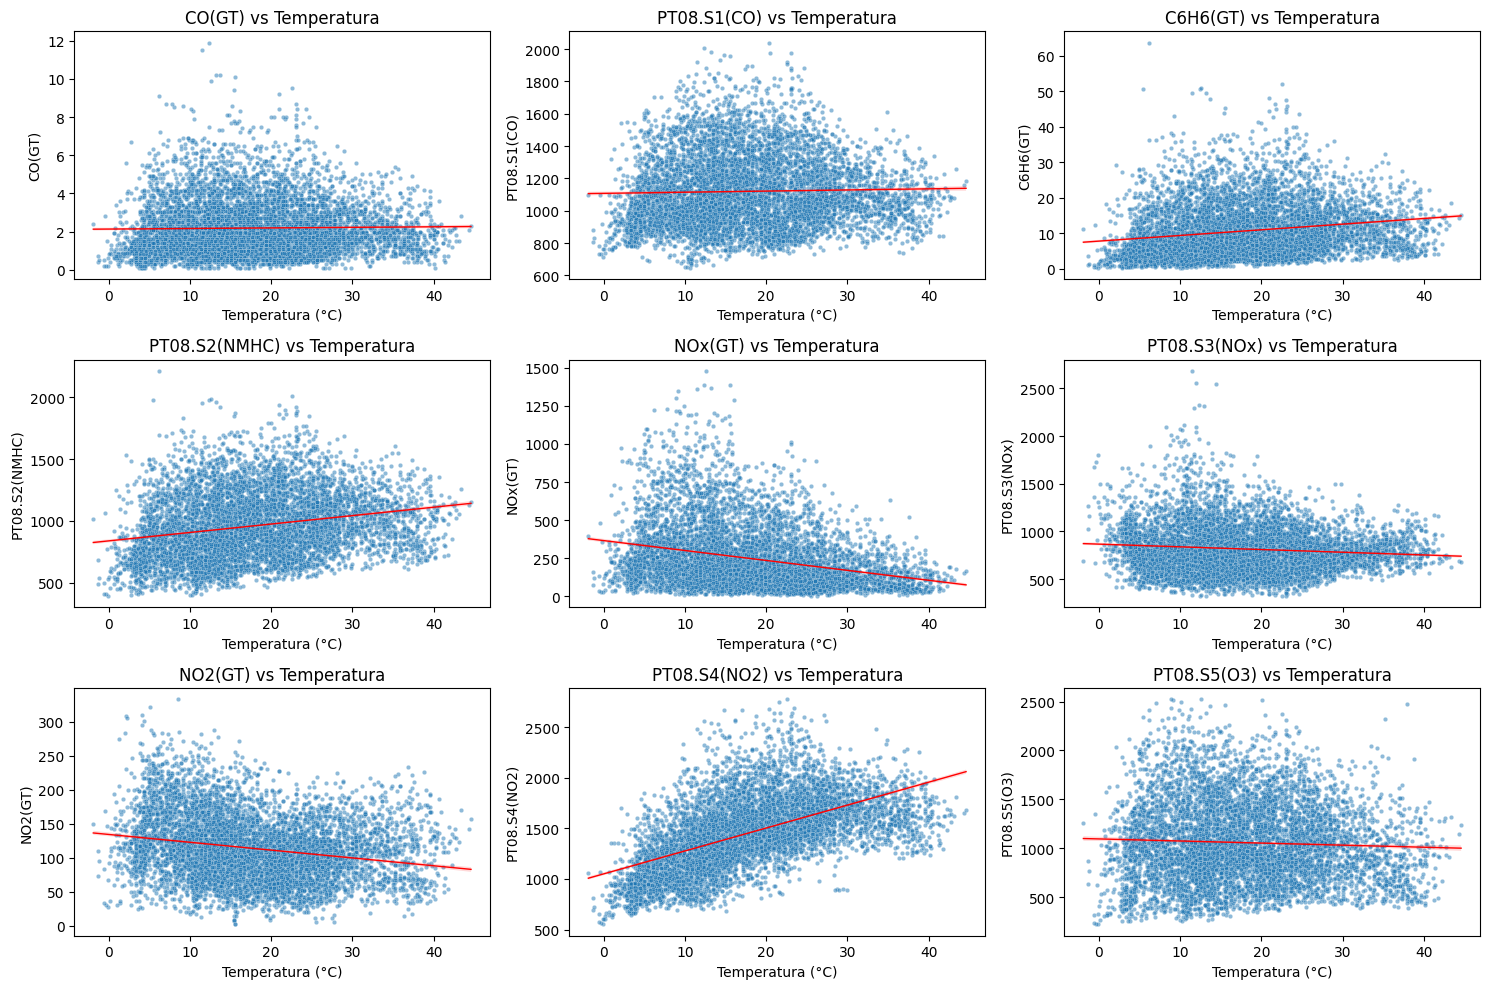

In [40]:
pollutant_columns = [
    'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 
    'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 
    'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)'
]

plt.figure(figsize=(15, 10))

for i, col in enumerate(pollutant_columns, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(x='T', y=col, data=df, s=10, alpha=0.5)
    sns.regplot(x='T', y=col, data=df, scatter=False, color='red', line_kws={'linewidth':1})
    plt.title(f'{col} vs Temperatura')
    plt.xlabel('Temperatura (°C)')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

Nas figuras onde temos os pontos, vemos as maiores concentração com menores temperaturas.

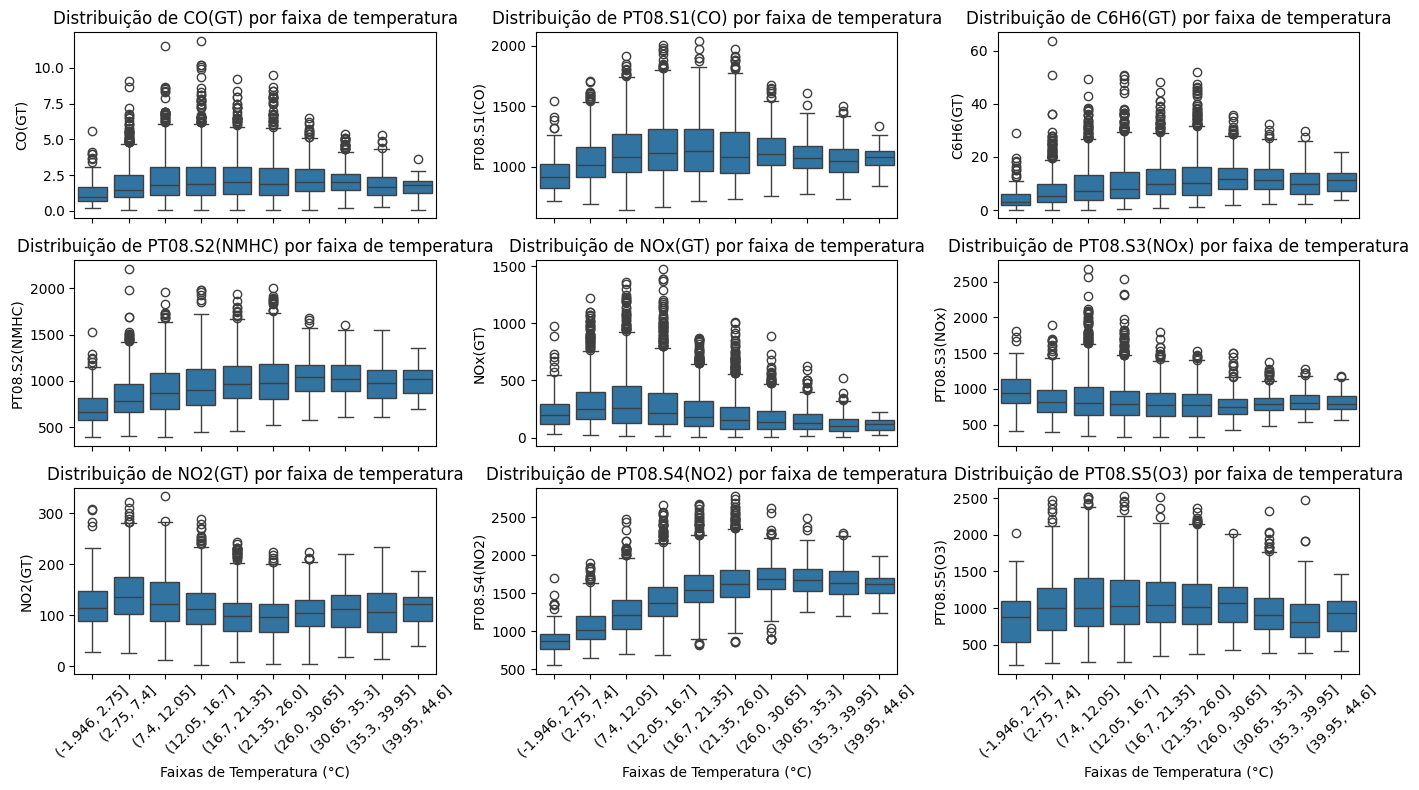

In [41]:
# Categorias de temperatura
df["T_bin"] = pd.cut(df["T"], bins=10)

pollutant_columns = [
    'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)',
    'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)'
]

fig, axes = plt.subplots(3, 3, figsize=(14,8), sharex=True)
axes = axes.flatten()

for i, pol in enumerate(pollutant_columns):
    sns.boxplot(x="T_bin", y=pol, data=df, ax=axes[i])
    axes[i].set_title(f"Distribuição de {pol} por faixa de temperatura")
    axes[i].set_xlabel("Faixas de Temperatura (°C)")
    axes[i].set_ylabel(pol)
    axes[i].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

Pode-se destacar três pontos das análises temporais:

* Os gases apresentam concentrações mais elevadas no início da manhã no fim da tarde e ínicio da noite, coincidindo com horários de pico de tráfego. 

* Ao longo do ano, os meses de inverno concentram valores médios mais altos, explicados pela maior estabilidade atmosférica, como pode ser observado no nascer e por do sol e menor dispersão dos poluentes dada as temperaturas.

* Existem registros de valores anormalmente altos, que podem indicar tanto episódios críticos de poluição quanto falhas pontuais de medição.

Na matriz de correlação, vemos que as correlações altas entre os poluentes vão indicar fontes em comuns.

Para uma melhor análise podemos estudar os cofiecientes de Pearson-Spearman para enteder as relações

**O dataset apresenta algumas falhas em sensores, distribuições assimétricas e podemos observar padrões temporais sazonais, e uma relação entre poluentes e condições clima. Assim, ele reforça a importância de fatores de tráfego e clima na qualidade do ar**

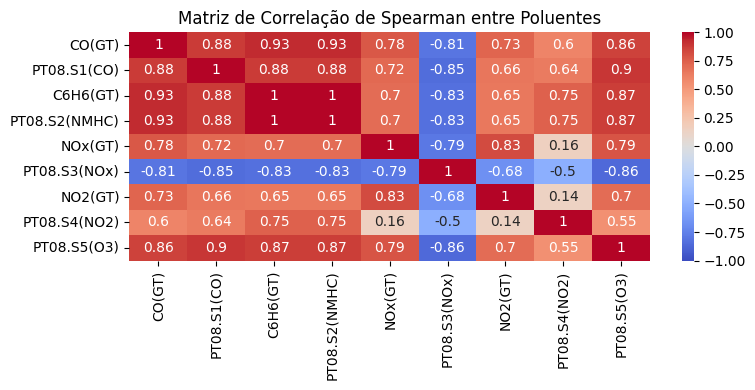

In [42]:
# Coeficiente de Spearman entre os poluentes
spearman_corr = df[pollutant_columns].corr(method='spearman')
plt.figure(figsize=(8, 4))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação de Spearman entre Poluentes')
plt.tight_layout()
plt.show()

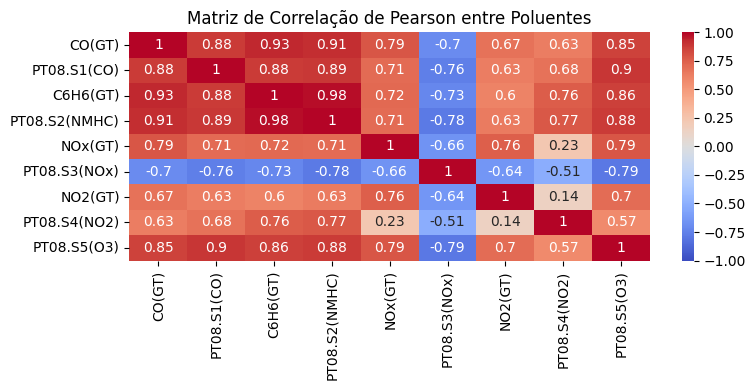

In [43]:
# Coeficiente de Pearson entre os poluentes
pearson_corr = df[pollutant_columns].corr(method='pearson')
plt.figure(figsize=(8, 4))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação de Pearson entre Poluentes')
plt.tight_layout()
plt.show()

In [44]:
df_original.corr()

,datetime,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
datetime,1.000000,0.136673,-0.050633,-0.074370,-0.104596,0.380543,-0.237531,0.233377,-0.419744,0.055679,-0.153011,0.009496,-0.067382
CO(GT),0.136673,1.000000,0.041411,-0.031378,0.029926,0.526451,-0.089981,0.671127,-0.073724,0.080310,-0.068939,-0.048227,-0.045892
PT08.S1(CO),-0.050633,0.041411,1.000000,0.852687,0.933102,0.277993,0.087019,0.154030,0.845149,0.892434,0.754844,0.745375,0.764903
C6H6(GT),-0.074370,-0.031378,0.852687,1.000000,0.767433,-0.001174,0.512193,-0.010992,0.774673,0.641334,0.971375,0.925062,0.984555
PT08.S2(NMHC),-0.104596,0.029926,0.933102,0.767433,1.000000,0.331272,-0.073667,0.176488,0.874782,0.909905,0.669025,0.585803,0.646572
NOx(GT),0.380543,0.526451,0.277993,-0.001174,0.331272,1.000000,-0.436084,0.817139,0.035546,0.461889,-0.138452,-0.053009,-0.095847
PT08.S3(NOx),-0.237531,-0.089981,0.087019,0.512193,-0.073667,-0.436084,1.000000,-0.256232,0.122734,-0.208865,0.588111,0.573549,0.621618
NO2(GT),0.233377,0.671127,0.154030,-0.010992,0.176488,0.817139,-0.256232,1.000000,-0.022174,0.253439,-0.084104,-0.081305,-0.060440
PT08.S4(NO2),-0.419744,-0.073724,0.845149,0.774673,0.874782,0.035546,0.122734,-0.022174,1.000000,0.723690,0.755060,0.640707,0.691913
PT08.S5(O3),0.055679,0.080310,0.892434,0.641334,0.909905,0.461889,-0.208865,0.253439,0.723690,1.000000,0.503700,0.524955,0.519467


Analisando os coeficientes de Spearman e Pearson vemos que:
* Spearman: As variáveis apresentam uma relação monotônica positiva forte, então tem uma tendencia aumentar;
* Pearson: As variáveis tem uma relação linear forte, se movendo juntas, por conta dos momentos de maior movimento.

### <p style="text-align:center;">Modelos estatísticos</p>

Os modelos estatísticos vão ser utilizados para prever a relação entre a úmidade e a concentração dos gases na atmosfera.

O primeiro modelo utilizado vai ser a Regressão Linear

In [59]:
X=df_original[['CO(GT)', 'PT08.S1(CO)',	'C6H6(GT)',	'PT08.S2(NMHC)', 'NOx(GT)',	'PT08.S3(NOx)',	'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T']]
#y=df_original[['RH']]
y=df_original[['RH','AH']]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3)

In [60]:
reg=LinearRegression()
reg.fit(X_train, y_train)
y_pred=reg.predict(X_test)
y_pred
print(r2_score(y_test,y_pred))

0.9642172644137745


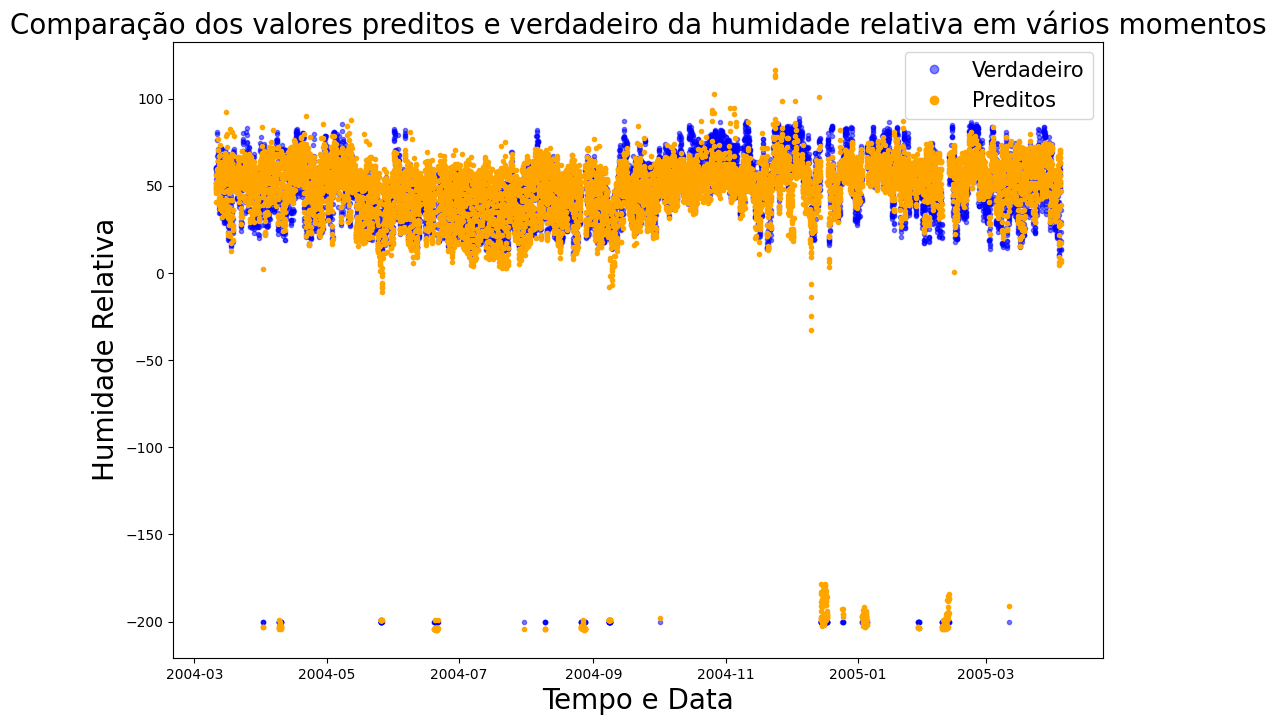

In [61]:
X=df_original[['CO(GT)', 'PT08.S1(CO)',	'C6H6(GT)',	'PT08.S2(NMHC)', 'NOx(GT)',	'PT08.S3(NOx)',	'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T']]
y_pred_all=reg.predict(X)
df_original['RH_pred']=y_pred_all[:,0]
df_original['AH_pred']=y_pred_all[:,1]

plt.figure(figsize=(12,8))
plt.plot_date(df_original.datetime, df_original.RH, color='blue', marker='.', label="Verdadeiro", alpha=0.5)
plt.plot_date(df_original.datetime, df_original.RH_pred, color='orange',marker='.', label="Preditos")
plt.title("Comparação dos valores preditos e verdadeiro da humidade relativa em vários momentos", fontsize=20)
plt.xlabel("Tempo e Data", fontsize=20)
plt.ylabel("Humidade Relativa", fontsize=20)
plt.legend(fontsize=15, facecolor='white', markerscale=2)

In [48]:
print ('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print ('MSE:', metrics.mean_squared_error(y_test, y_pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print ('R²:', r2_score(y_test, y_pred)) 


MAE: 4.133433189844163
MSE: 47.284657604712635
RMSE: 6.876384050117666
R²: 0.9808989061645025


Agora, vamos ver os erros com modelos de árvores de decisão

In [50]:
forest = RandomForestRegressor(n_estimators=1000,  
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE Train: %.3f, Test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R² Train: %.3f, Test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE Train: 2.147, Test: 14.065
R² Train: 0.999, Test: 0.994


Observamos valores de $R^2$ muito próximos de $1$ significa que o $fit$ das variáveis está muito bom. Porque quanto maior a quantidade de pontos que estão sob a linha maior a porcentagem do $R^2$.

Agora, removeremos os outliers para ver a qualidade dos métodos estatísticos para garantir uma análise que represente melhor o comportamento e que evite dados distorcidos.

In [51]:
# Lista de colunas dos poluentes
pollutant_columns = [
    'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 
    'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 
    'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)'
]

# Fazer uma cópia para preservar o original
df_sem_outliers = df.copy()

# Loop sobre cada coluna e aplicar o método IQR
for col in pollutant_columns:
    Q1 = df_sem_outliers[col].quantile(0.25)
    Q3 = df_sem_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    df_sem_outliers = df_sem_outliers[
        (df_sem_outliers[col] >= limite_inferior) &
        (df_sem_outliers[col] <= limite_superior)
    ]

print("Antes:", df.shape)
print("Depois:", df_sem_outliers.shape)

Antes: (6941, 14)
Depois: (6091, 14)


Regressão Linear

In [52]:
X=df_sem_outliers[['CO(GT)', 'PT08.S1(CO)',	'C6H6(GT)',	'PT08.S2(NMHC)', 'NOx(GT)',	'PT08.S3(NOx)',	'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T']]
y=df_sem_outliers[['RH','AH']]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3)
reg=LinearRegression()
reg.fit(X_train, y_train)
y_pred=reg.predict(X_test)
y_pred
print(r2_score(y_test,y_pred))

0.8577543450434113


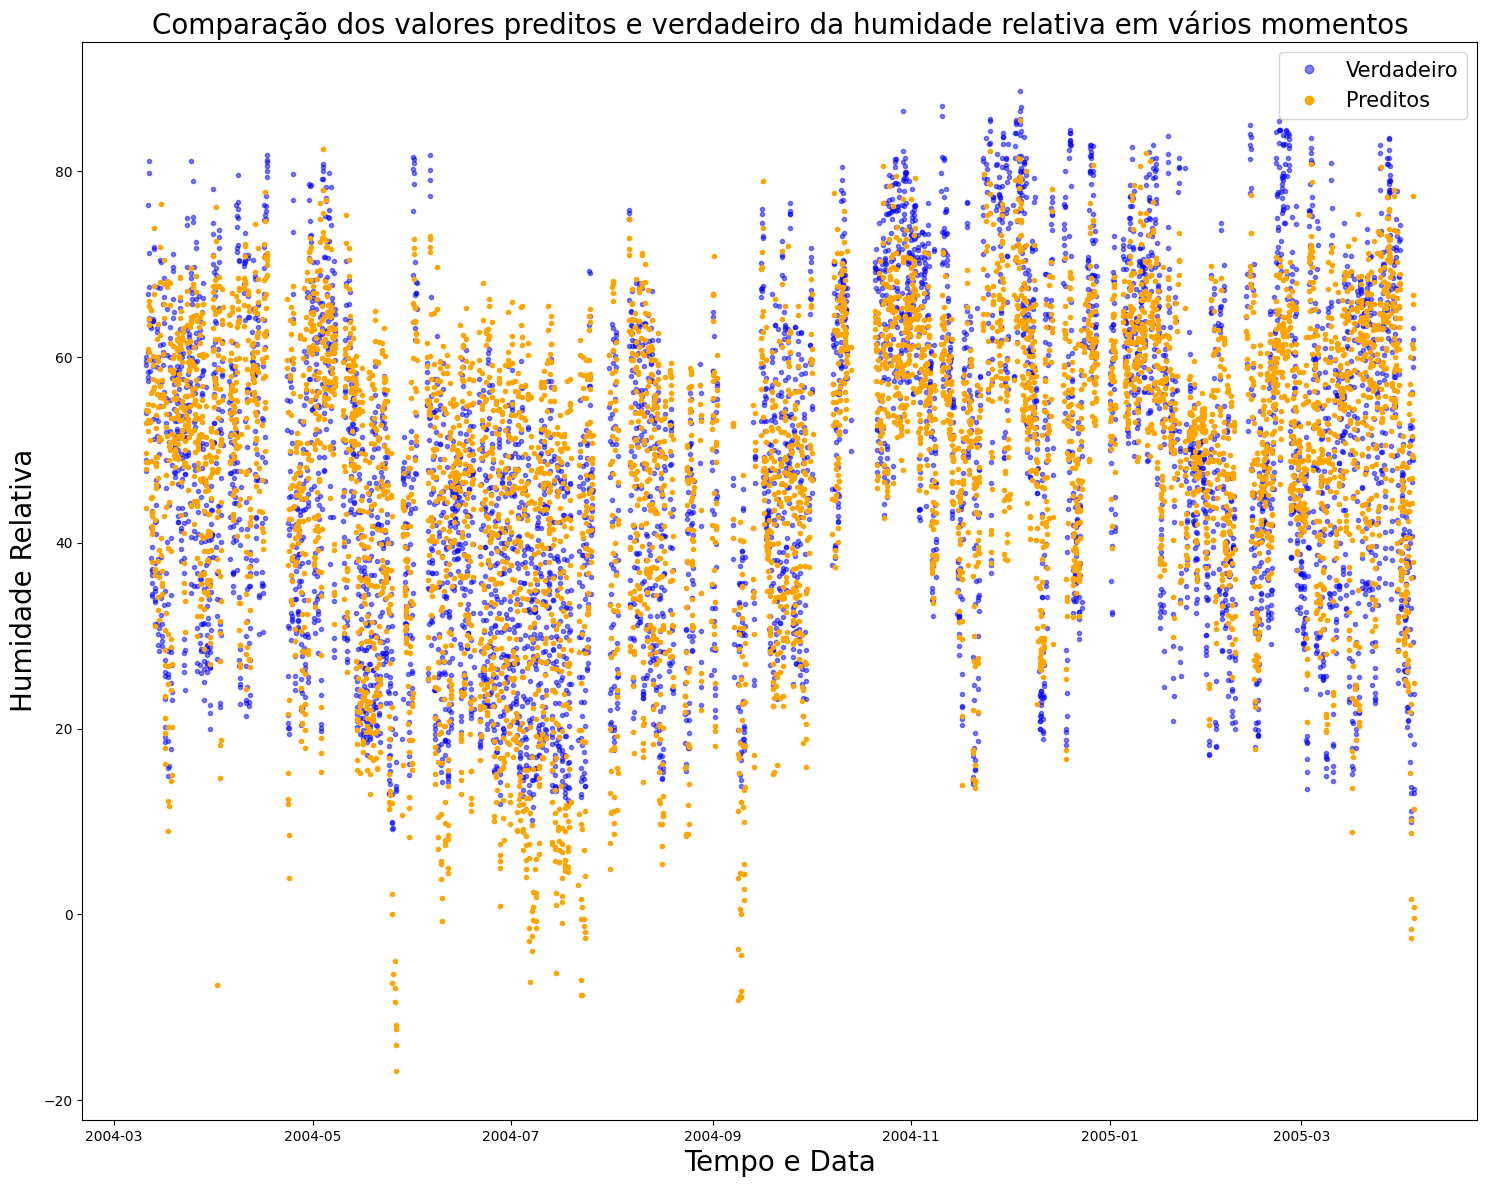

In [53]:
X=df_sem_outliers[['CO(GT)', 'PT08.S1(CO)',	'C6H6(GT)',	'PT08.S2(NMHC)', 'NOx(GT)',	'PT08.S3(NOx)',	'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T']]
y_pred_all=reg.predict(X)
df_sem_outliers['RH_pred']=y_pred_all[:,0]
df_sem_outliers['AH_pred']=y_pred_all[:,1]
plt.figure(figsize=(18,14))
plt.plot_date(df_sem_outliers.datetime, df_sem_outliers.RH, color='blue', marker='.', label="Verdadeiro", alpha=0.5)
plt.plot_date(df_sem_outliers.datetime, df_sem_outliers.RH_pred, color='orange', marker='.', label="Preditos")
plt.title("Comparação dos valores preditos e verdadeiro da humidade relativa em vários momentos", fontsize=20)
plt.xlabel("Tempo e Data", fontsize=20)
plt.ylabel("Humidade Relativa", fontsize=20)
plt.legend(fontsize=15, facecolor='white', markerscale=2)

In [54]:
print ('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print ('MSE:', metrics.mean_squared_error(y_test, y_pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print ('R²:', r2_score(y_test, y_pred)) 

MAE: 2.8707817996440643
MSE: 25.343278676844044
RMSE: 5.034210829598225
R²: 0.8577543450434113


Modelos baseados em árvores de decisão

In [55]:
forest = RandomForestRegressor(n_estimators=1000,  
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE Train: %.3f, Test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R² Train: %.3f, Test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE Train: 2.130, Test: 15.953
R² Train: 0.987, Test: 0.903


### <p style="text-align:center;">Conclusão</p>


As análises de correlação indicaram que as variáveis meteorológicas, especialmente temperatura e umidade, influenciam diretamente as concentrações de alguns poluentes, o que é consistente com o comportamento
Em relação à previsão, o modelo baseado em árvores de decisão apresentou melhor desempenho que o modelo linear, obtendo menores valores de RMSE e MAE e maior $R^2$ o que indica maior capacidade de capturar relações não lineares entre as variáveis.

Apesar dos resultados positivos, o estudo apresenta limitações associadas à qualidade dos dados, como registros ausentes e ausência de informações geográficas, o que pode impactar a generalização dos modelos.